# Exercise 4 - Part A

### Necessary imports

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from nltk import tokenize
from itertools import combinations
from sentence_transformers import SentenceTransformer, util

plt.style.use('dark_background')

### Data loading

In [19]:
def load_data(filename: str) -> pd.DataFrame:
    with open('data/' + filename, "r", encoding='utf8') as f:
        lines = f.read().replace("\n", " ")
        sentences = tokenize.sent_tokenize(lines)
        df = pd.DataFrame(sentences, columns=["sentence"])
    return df

## Sentence Bert Embeddings + Cosine Similarity

### Obtaining the embeddings of the sentences

In [20]:
# Bert Embeddings for each sentence
def get_embeddings(df: pd.DataFrame, sentences: list):
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    bert_embeddings_definition = model.encode(sentences, convert_to_tensor=True)
    df['embeddings'] = bert_embeddings_definition.tolist()

### Function for calculating the cosine similarity between adjacent blocks
- I calculate for each blocks the mean of the cosine similarity for obtaining a single value for each block (a cluster).
- I calculate the cosine similarity between blocks for calculating the similarity inter-blocks.

In [21]:
def calculate_cosine_similarity(df: pd.DataFrame, blocks_index: list) -> list:
    blocks_embeddings = []

    # For each block, calculate the mean of the embeddings
    for i in range(len(blocks_index) + 1):
        if i == 0:
            blocks_embeddings.append(np.mean(df['embeddings'][0:blocks_index[0]].tolist(), axis=0))
        elif i == len(blocks_index):
            blocks_embeddings.append(np.mean(df['embeddings'][blocks_index[i-1]:].tolist(), axis=0))
        else:
            blocks_embeddings.append(np.mean(df['embeddings'][blocks_index[i-1]:blocks_index[i]].tolist(), axis=0))
    
    # Calculate the cosine similarity between each adjacent block
    final_blocks_embeddings = []
    for i in range(len(blocks_embeddings) - 1):
        final_blocks_embeddings.append(util.cos_sim(blocks_embeddings[i], blocks_embeddings[i+1]).item())
    return final_blocks_embeddings

### Function for obtaining the peaks
- I calculate all the similarities between a sentence and the next one.
- I find the similarities n (index of peak) that has a similarity > 0.2 by the difference of n-2 and n-1 (bottom peak), and the difference of n-1 and n has a similarity > threshold (upper peak). We do this until we have at least n_cuts peaks, so we get at least the number of cuts we want.
- I plot the peaks and the cosine similarity between blocks.

In [22]:
def get_peaks(df: pd.DataFrame, filename: str, n_cuts: int) -> list:
    # Calculating the similarity between each adjacent sentences
    similarity = []
    for index, sentence_embedding in enumerate(df['embeddings']):
        similarity.append(util.cos_sim(sentence_embedding, df['embeddings'][index + 1]).item() if index < len(df['embeddings']) - 1 else 0)
    similarity = np.array(similarity)

    # Finding the similarities n that has a distance > 0.2 from n - 1 and the 
    # n-2 and n-1 has a distance > threshold (we have a peak and before we had a bottom peak)
    # We do this until we have at least n_cuts peaks
    peaks = []
    threshold = 0.2
    
    while len(peaks) < n_cuts:
        for index in range(len(similarity)):
            if index > 2:
                if similarity[index - 2] - similarity[index - 1] > threshold and similarity[index] - similarity[index - 1] > threshold:
                    if index not in peaks:
                        peaks.append(index)
        threshold -= 0.01
    peaks = sorted(peaks)
    
    # Plotting the peaks on the similarity graph
    plt.figure(figsize=(15,6))
    plt.xticks(np.arange(0, len(df), 2))
    plt.xlabel("Sentence")
    plt.ylabel("Similarity")
    plt.plot(similarity)
    plt.plot(peaks, similarity[peaks], "x", color='red')
    plt.title(filename)
    plt.show()

    return peaks

### Function for calculating the similarity between blocks generated from the peaks and finding the blocks that has the mininum similarity
- I get all the combinations of peaks (possible breakpoints) and calculate the similarity between all the possible combinations.
- I sum all the similarities beetween blocks and i sort the similarities of all combinations and i get the one with the minimum similarity.
- I return the breakpoints

In [29]:
def get_best_breakpoints(df: pd.DataFrame, peaks: list, n_cuts: int) -> list:
    blocks_similarity_between = {}

    # Getting all the combinations of peaks with a certain number of cuts
    breakpoints_combinations = list(combinations(peaks, n_cuts))

    # Calculating the similarity of blocks changing the index blocks with all the combinations of peaks found
    for combination in breakpoints_combinations:
        breakpoints_index = list(combination)
        blocks_similarity_between['_'.join(list(map(str, breakpoints_index)))] = calculate_cosine_similarity(df, breakpoints_index)

    # I sum all the similarities between the blocks
    temp_breakpoints_index = {val: sum(blocks_similarity_between[val]) for val in blocks_similarity_between.keys()}

    # Sorting all the combinations for finding the combination with the lowest similarity inter-blocks
    breakpoints_index = {k: v for k, v in sorted(temp_breakpoints_index.items(), key=lambda item: item[1])}

    return [int(index) for index in next(iter(breakpoints_index)).split("_")]

### Function for creating the output files
- I create the output files with the paragraphs splitted by the breakpoints.

In [24]:
def get_output_files(breakpoints_index: list, sentences: list, filename: str, n_groups: int = None):
    with open("out/" + filename, "w+", encoding='utf8') as f:
        for i in range(len(breakpoints_index) + 1):
            print("Paragraph " + str(i+1) + ": ", file=f)
            if i == 0:
                for sentence in sentences[0:breakpoints_index[i]]:
                    if n_groups:
                        sentences_splitted = tokenize.sent_tokenize(sentence)
                        for sentence_split in sentences_splitted:
                            print(sentence_split, file=f)
                    else:
                        print(sentence, file=f)
            elif i == len(breakpoints_index):
                for sentence in sentences[breakpoints_index[i-1]:]:
                    if n_groups:
                        sentences_splitted = tokenize.sent_tokenize(sentence)
                        for sentence_split in sentences_splitted:
                            print(sentence_split, file=f)
                    else:
                        print(sentence, file=f)
            else:
                for sentence in sentences[breakpoints_index[i-1]:breakpoints_index[i]]:
                    if n_groups:
                        sentences_splitted = tokenize.sent_tokenize(sentence)
                        for sentence_split in sentences_splitted:
                            print(sentence_split, file=f)
                    else:
                        print(sentence, file=f)
            print("\n\n", file=f) if i != len(breakpoints_index) else None

## Cycles for getting the results for every data resource

* data1.txt is composed by three paragraphs of different domains:
    * Soccer;
    * Big Ben;
    * Circular Economy  
- data2.txt is composed by four paragraphs of different domains:
    * Sanford Koufax (ex American baseball pitcher);
    * The Dorilton (Luxury residential housing in New York City);
    * Tina Turner;
    * Oak
* data3.txt is composed by three paragraphs of same domain:
    * Valentino Rossi;
    * Marc Márquez;
    * Jorge Lorenzo

### First Method: Similarity between adjacent sentences

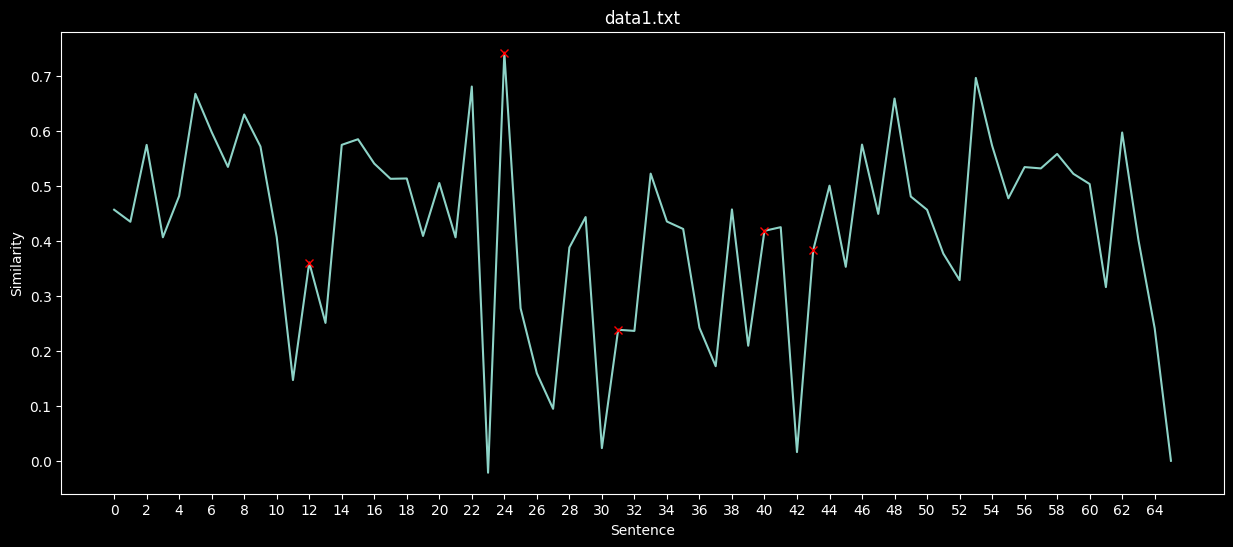

Best breakpoints founded:  [24, 43]
Correct breakpoints:  [24, 43]


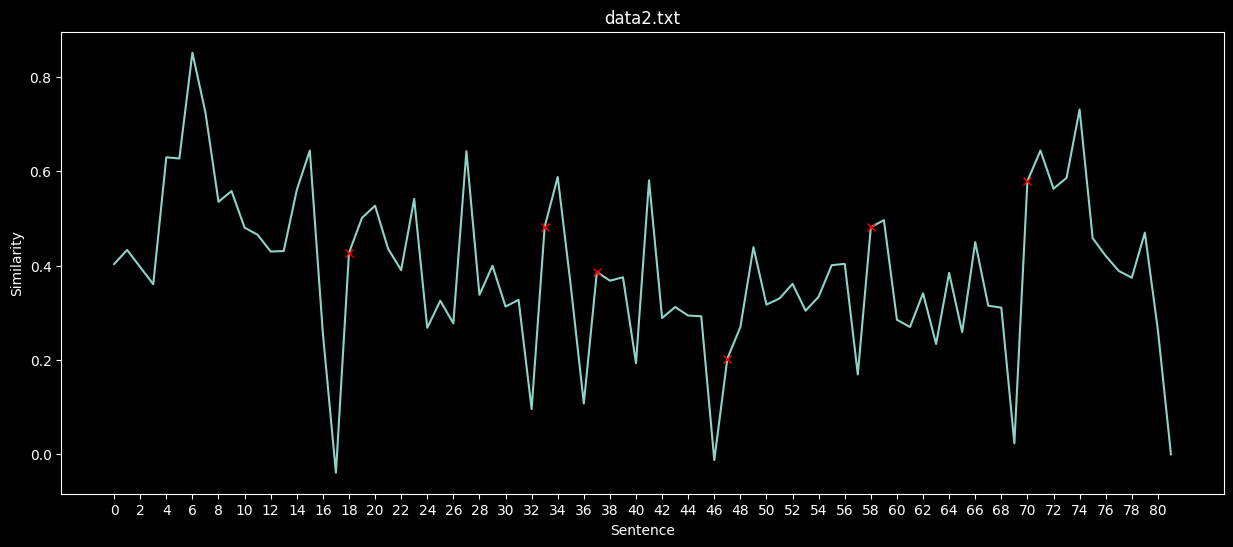

Best breakpoints founded:  [18, 47, 70]
Correct breakpoints:  [18, 47, 70]


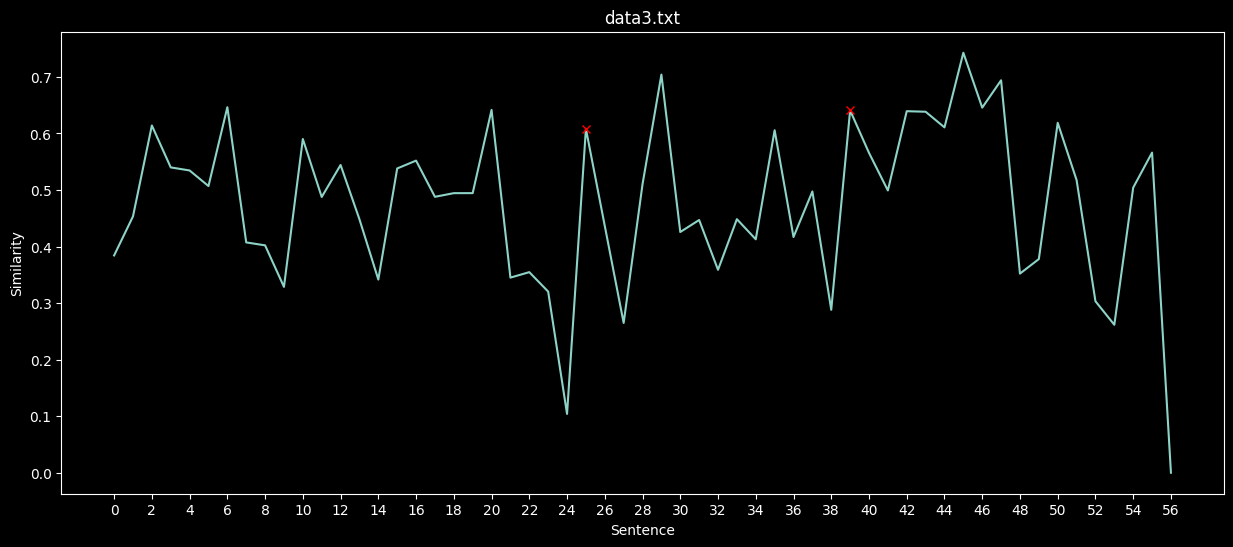

Best breakpoints founded:  [25, 39]
Correct breakpoints:  [23, 39]


In [30]:
# I set the correct breakpoints for each file
correct_breakpoints = [[24, 43], [18, 47, 70], [23, 39]]

# For each file, I load the data, I get the embeddings and I find the best breakpoints.
# Then I print the paragraphs founded and a comparison between the best breakpoints and the correct ones
for index, filename in enumerate(os.listdir('data')):
    df = load_data(filename)
    get_embeddings(df, df['sentence'].tolist())
    peaks = get_peaks(df, filename, len(correct_breakpoints[index]))
    best_breakpoints = get_best_breakpoints(df, peaks, len(correct_breakpoints[index]))
    get_output_files(best_breakpoints, df['sentence'], filename)
    print("Best breakpoints founded: ", best_breakpoints)
    print("Correct breakpoints: ", correct_breakpoints[index])

### Second Method: Similarity between adjacent groups of two sentences

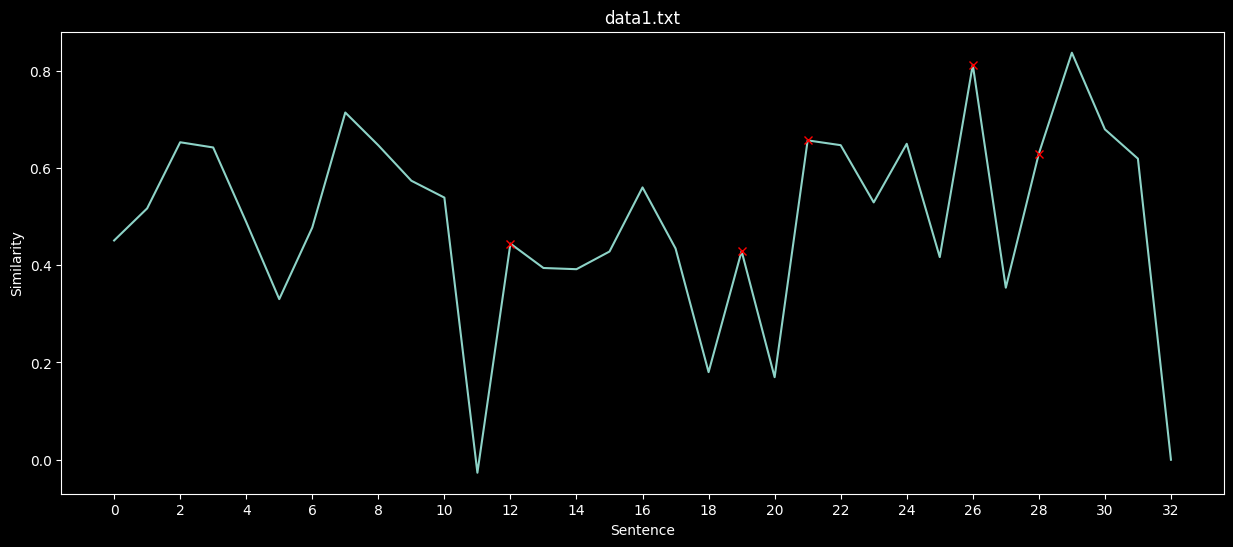

Best breakpoints founded:  [12, 21]
Correct breakpoints:  [12, 21]


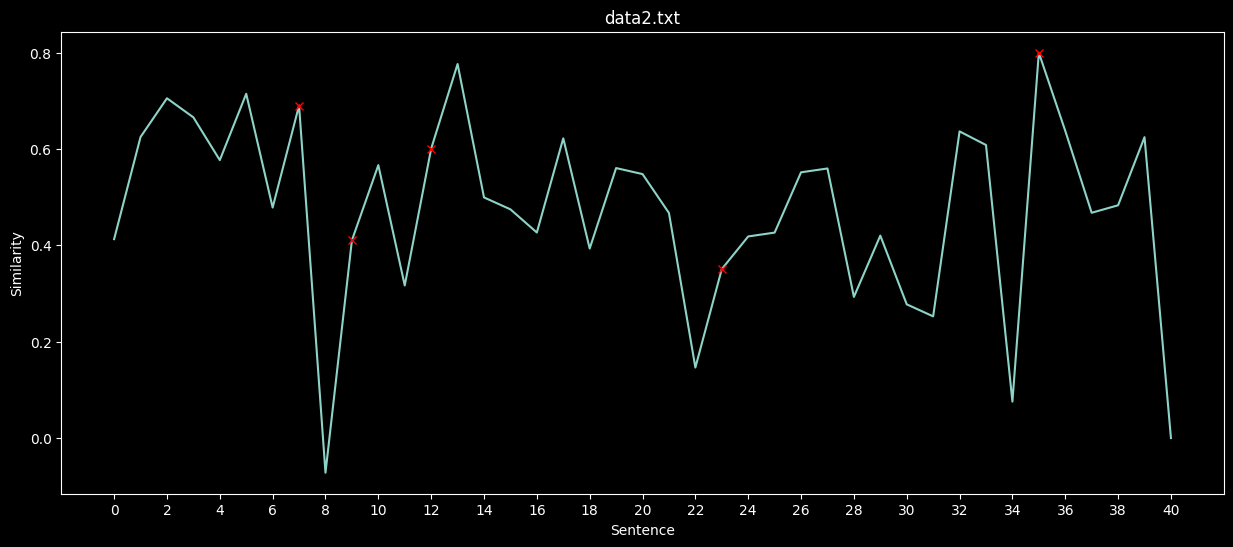

Best breakpoints founded:  [9, 23, 35]
Correct breakpoints:  [9, 23, 35]


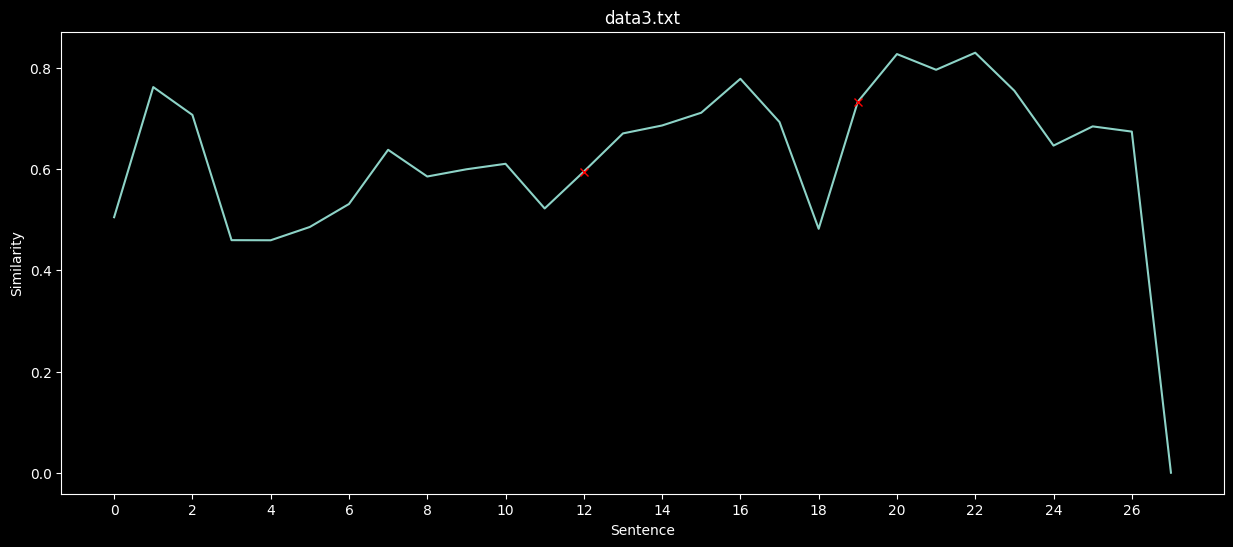

Best breakpoints founded:  [12, 19]
Correct breakpoints:  [12, 20]


In [31]:
# Same method, but i use group of two sentences instead of one
correct_breakpoints = [[12, 21], [9, 23, 35], [12, 20]]
n_groups = 2
for index, filename in enumerate(os.listdir('data')):
    df = load_data(filename)
    df_combined = pd.DataFrame(columns=['sentence'])
    for i in range(0, len(df['sentence']) - 1, n_groups):
        df_combined.loc[len(df_combined)] = [' '.join(df['sentence'][i:i+n_groups])]
    get_embeddings(df_combined, df_combined['sentence'].tolist())
    peaks = get_peaks(df_combined, filename, len(correct_breakpoints[index]))
    best_breakpoints = get_best_breakpoints(df_combined, peaks, len(correct_breakpoints[index]))
    get_output_files(best_breakpoints, df_combined['sentence'], filename + "_combined", n_groups)
    print("Best breakpoints founded: ", best_breakpoints)
    print("Correct breakpoints: ", correct_breakpoints[index])